In [1]:
import os
import pathlib
import torch
import pandas as pd
import torchvision

from torchinfo import summary
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch import nn

EPOCHS  = 10

BATCH_SIZE = 1

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

class BirdDataSet(Dataset):
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self,csv_file:str , dataset: str ,targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        #The file read in is a dataframe, process it base on dataframe.
      self.annotations = pd.read_csv(targ_dir + "/"+ csv_file)

      #If we don't reset_index(), we would get the wrong index number when extracting data from test or valid
      #Since they start counting from e.g. 62000. Then the index would start from 62000, yet, we want it
      #to start from 0. So we would like to reset the index to allow counting from 0.
      self.dataframe = self.annotations[self.annotations["data set"] == dataset].reset_index()

      self.paths = [pathlib.Path(folder_path + "/" + p) for p in self.dataframe["filepaths"]]

      # Setup transforms
      self.transform = transform

      # Create classes and class_to_idx attributes
      self.classes, self.class_to_idx = find_classes(targ_dir + "/" + dataset)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.ut
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dat
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name = self.paths[index].parent.stem #<- (c:/a/b/c).parent.stem = (c:/a/b).stem = b
        class_idx = self.class_to_idx[class_name] #<- select the idx from the class name

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [2]:
#Load in the module from torchvision using transfer learning
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
# Get the transform from the specified model
device = device = "cuda" if torch.cuda.is_available() else "cpu"
weights = torchvision.models.VGG16_Weights.DEFAULT # .DEFAULT = best available weights 
auto_transform = weights.transforms()
print(auto_transform)


model = torchvision.models.vgg16(weights=weights).to(device)
#Printing out module summary.
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   1,792                True
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   36,928               True
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  73,856               True
│    └─ReLU (6)     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img shape: torch.Size([32, 3, 224, 224])
label shape:torch.Size([32])
Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'ABBOTTS BABBLER')

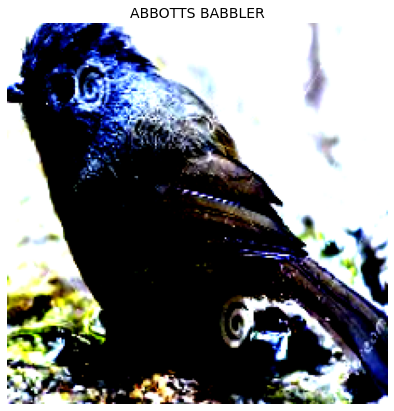

In [3]:

#Playing with the dataSet
# annotation = pd.read_csv(folder_path + "/birds.csv")
# dataframe  = annotation[annotation["data set"] == "train"].reset_index()
# paths = [pathlib.Path(folder_path + "/" + p) for p in dataframe["filepaths"]]
#
# frame = dataframe["filepaths"]
# print()
# class_name = paths[0].parent.stem
# print(paths)

# Don't augment test data, only reshape
folder_path = "D:/archive"
csv_file    = "birds.csv"

train_set = BirdDataSet(csv_file,"train",folder_path,auto_transform)
test_set  = BirdDataSet(csv_file,"test",folder_path,auto_transform)
valid_set = BirdDataSet(csv_file,"valid",folder_path,auto_transform)

train_dataloader  =  DataLoader(test_set,batch_size=32,shuffle=True)
test_dataloader   =  DataLoader(test_set,batch_size=32,shuffle=True)
valid_dataloader  =  DataLoader(test_set,batch_size=32,shuffle=True)

#Check the size of tensor and visualize data when going through every step to ensure
#~bug free code

img,label = next(iter(train_dataloader))

print(f"img shape: {img.shape}")
print(f"label shape:{label.shape}")


#<- f ix class_to_idx
# print(train_set.classes)
# print(train_set.class_to_idx)

#Exploring image data
img,label = train_set[0][0],train_set[0][1]

#Classes
class_names = train_set.classes

# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
#For image to be plotted , permutation must be used.
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14)

In [4]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

# Set the manual seeds, These makes debug easier.
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)
print(len(class_names))

#Knows the classifier
print(model.classifier)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=25088, #<-Remember with different model, the length of classfier might varies.
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

400
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [5]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 400]            --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU (

In [6]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
from train import *

#train a single batch first for a couple of epochs,then see if the machine is working right


#Train with train helper function
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 9.0899 | train_acc: 0.2083 | test_loss: 0.2061 | test_acc: 0.9663
Epoch: 2 | train_loss: 0.4324 | train_acc: 0.9534 | test_loss: 0.0037 | test_acc: 0.9985
Epoch: 3 | train_loss: 0.0205 | train_acc: 0.9955 | test_loss: 0.0022 | test_acc: 0.9985
Epoch: 4 | train_loss: 0.0036 | train_acc: 0.9985 | test_loss: 0.0000 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.0000 | test_acc: 1.0000
[INFO] Total training time: 428.161 seconds


[INFO] Couldn't find helper_functions.py, downloading...


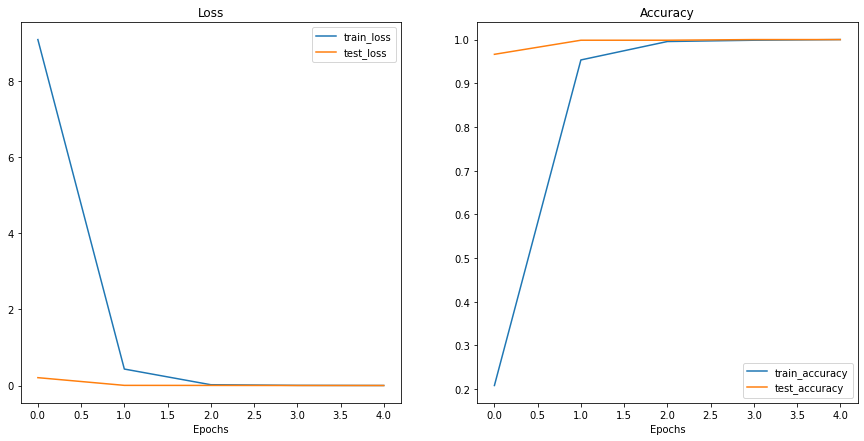

In [8]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [9]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str,  
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

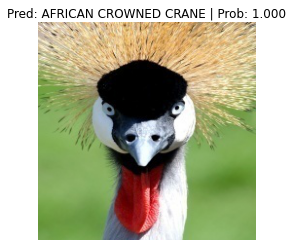

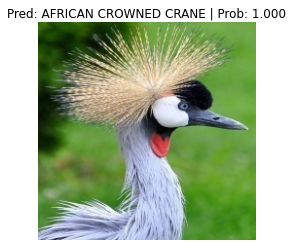

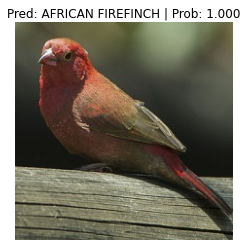

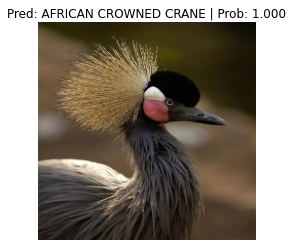

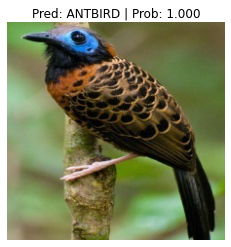

In [13]:
#Validation
# Get a random list of image paths from test set
import random
from pathlib import Path

valid_dir = "D:/archive/"

num_images_to_plot = 5
test_image_path_list = list(Path(valid_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        transform=auto_transform, # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

In [14]:
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [15]:
# Create an example writer
example_writer = create_writer(experiment_name="BirdDataSet",
                               model_name="VGG16",
                               extra="5_epochs")


[INFO] Created SummaryWriter, saving to: runs\2022-08-31\BirdDataSet\VGG16\5_epochs...


In [16]:
#Saving the model for later use
from pathlib import Path

#Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True,exist_ok=True)

#Create model save path
MODEL_NAME = "BirdDataSet_model0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#Save model state dict
print(f"Saving model to:{MODEL_SAVE_PATH}")
torch.save(obj = model.state_dict(), f = MODEL_SAVE_PATH)


Saving model to:models\BirdDataSet_model0.pth


In [17]:
#Evaluation

# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(valid_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)



Making predictions:   0%|          | 0/63 [00:00<?, ?it/s]